# Machine learning to predict new crescent moon visibility

## Imports

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# MACHINE LEARNING IMPORTS
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from sklearn.preprocessing import MultiLabelBinarizer

## Reading in data

In [2]:
METHOD = True # replace seen column with method seen column
RANDOM = False # replace data with random arrays
CLOUDCUT = False # cut all complete cloud cover data points
GRID_SEARCH = False # gridsearch for best random forest hyperparameters
REPEAT_ACCURACY = False #Run 20 times and calculate average accuracy

In [3]:
icouk_data_file = '..\\Data\\icouk_sighting_data_with_params.csv'
icop_data_file = '..\\Data\\icop_ahmed_2020_sighting_data_with_params.csv'
alrefay_data_file = '..\\Data\\alrefay_2018_sighting_data_with_params.csv'
allawi_data_file = '..\\Data\\schaefer_odeh_allawi_2022_sighting_data_with_params.csv'

icouk_data = pd.read_csv(icouk_data_file)
icop_data = pd.read_csv(icop_data_file)
alrefay_data = pd.read_csv(alrefay_data_file)
allawi_data = pd.read_csv(allawi_data_file)

data = pd.concat([icouk_data,icop_data,alrefay_data,allawi_data])

print(f"Loaded {data.shape[0]} rows")

data = data.drop(["Index","q","W","q'","W'"], axis = 1)
data = data.drop(["Seen",'Method','Methods'], axis = 1) # replaced by method column

data.head(10)

Loaded 3626 rows


,Date,Latitude,Longitude,Moon Age,Sunset,Moonset,Lag,Moon Alt,Moon Az,Sun Alt,Sun Az,Moon-Earth Dist,Sun-Moon Dist,ARCL,ARCV,DAZ,Illumination,Parallax,Cloud Level,Visibility
0,2.457309e+06,53.95763,-1.08271,0.722,2.457309e+06,2.457309e+06,27.05935,1.51838,252.00232,-1.73173,259.02584,0.00271,0.99508,7.73820,3.25011,7.02353,0.00455,54.14174,1.0,0.0
1,2.457339e+06,53.95763,-1.08271,1.687,2.457339e+06,2.457339e+06,57.80819,3.36486,235.23797,-3.31808,243.97528,0.00266,0.98725,10.99616,6.68294,8.73731,0.00918,55.04632,0.5,0.0
2,2.457398e+06,53.95763,-1.08271,0.685,2.457398e+06,2.457398e+06,67.20869,3.82122,233.19221,-3.52379,236.46999,0.00252,0.98095,8.04228,7.34501,3.27778,0.00492,58.03155,0.5,0.0
3,2.457428e+06,53.58333,-2.43333,1.738,2.457428e+06,2.457428e+06,94.68585,6.40548,245.47535,-5.81151,253.06492,0.00244,0.98427,14.37485,12.21699,7.58956,0.01565,59.59324,1.0,0.0
4,2.457428e+06,52.63860,-1.13169,1.736,2.457428e+06,2.457428e+06,93.09817,6.46498,246.07108,-5.86126,253.40983,0.00244,0.98427,14.33820,12.32624,7.33875,0.01557,59.58563,0.0,1.0
5,2.457457e+06,52.63860,-1.13169,0.761,2.457457e+06,2.457457e+06,51.24933,3.50315,262.44978,-3.43885,267.72094,0.00240,0.99075,8.71450,6.94200,5.27116,0.00577,60.83454,1.0,0.0
6,2.457457e+06,51.87967,-0.41748,0.759,2.457457e+06,2.457457e+06,50.69011,3.53057,262.58959,-3.46038,267.74070,0.00240,0.99075,8.68183,6.99094,5.15110,0.00573,60.83247,0.5,0.0
7,2.457457e+06,51.39822,-0.19837,0.759,2.457457e+06,2.457457e+06,50.38849,3.55198,262.67600,-3.47683,267.75591,0.00240,0.99075,8.67048,7.02881,5.07991,0.00571,60.83099,1.0,0.0
8,2.457457e+06,53.95763,-1.08271,0.760,2.457457e+06,2.457457e+06,51.96781,3.43075,262.20043,-3.37986,267.64850,0.00240,0.99075,8.71957,6.81061,5.44807,0.00578,60.83909,1.0,0.0
9,2.457487e+06,53.58333,-2.43333,1.816,2.457487e+06,2.457487e+06,95.45765,6.69411,277.61713,-6.00369,291.47930,0.00240,0.99931,18.77762,12.69780,13.86218,0.02661,60.77741,1.0,0.0


## ML Training

In [4]:
# List of features without label feature
variable_list =  data.columns.tolist()
features = variable_list
#features.remove('Seen')
#print(features)

y = np.array(data['Visibility'])
features.remove('Visibility')

X = data[features]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # 80/20 training/test split

In [6]:
# Produce randomforest classifier model and fit to training data
# Keep the random_state=1 in your arguments
# gini or entropy
rf = RandomForestRegressor(n_estimators=100,n_jobs=-1)
# Fitting takes the input and "truth" data for classification purposes
rf.fit(x_train, y_train)

RandomForestRegressor(n_jobs=-1)

In [29]:
# Produce predictions for the classification of your training dataset using your model:
y_pred = rf.predict(x_train)

# plot the accuracies of said predictions
print("Mean abs error on training dataset:",mean_absolute_error(y_train, y_pred))
rf_acc_train = mean_absolute_error(y_train, y_pred)
y_pred = rf.predict(x_test)

print("Mean abs error on testing dataset:", mean_absolute_error(y_test, y_pred))
rf_acc_test = mean_absolute_error(y_test, y_pred)

Mean abs error on training dataset: 0.057475786124794745
Mean abs error on testing dataset: 0.17029151908697363


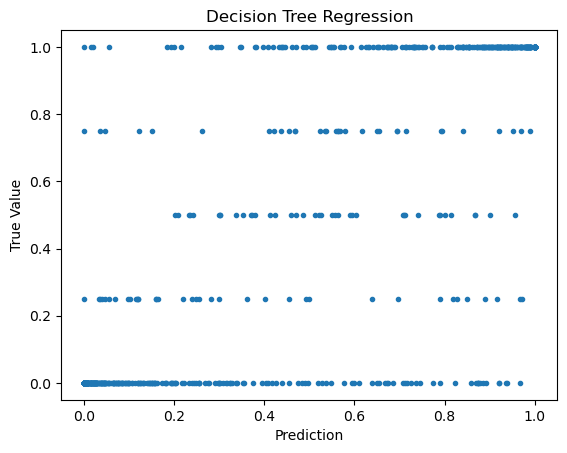

In [35]:
plt.figure()
#plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
#plt.plot(y_pred-y_test,y_test, "x")
plt.plot(y_pred,y_test, ".")

plt.ylabel("True Value")
plt.xlabel("Prediction")
plt.title("Decision Tree Regression")
plt.show()


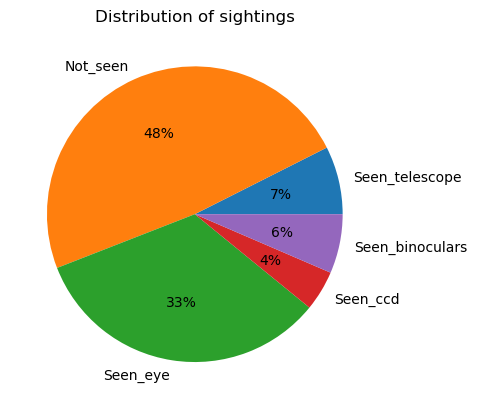

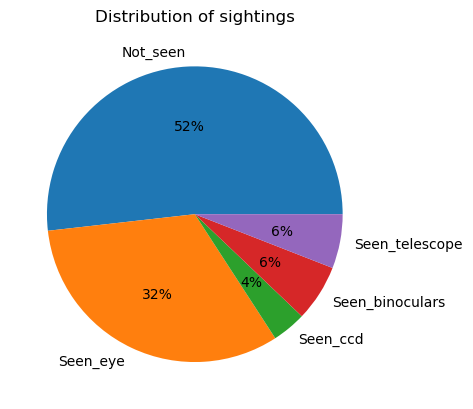

In [123]:
def plot_sightings(sights):
    sightings = pd.DataFrame(get_easiest_method_names(sights),columns =["Method"])
    pies = sightings["Method"].value_counts(sort=False)
    labels = sightings["Method"].unique()
    plt.pie(pies, labels=labels, autopct='%1.0f%%')
    plt.title('Distribution of sightings')
    plt.show()

if METHOD:
    plot_sightings(y_pred)
    plot_sightings(y_test)

In [124]:
# Plot importance
if not METHOD:
    importance = rf.feature_importances_
    ytix = features

    plt.barh(range(len(features)), importance)
    plt.yticks(range(len(features)), features)
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.show()

AttributeError: 'MultiOutputClassifier' object has no attribute 'feature_importances_'

Hyperparameter adjustment - not of much note yet

In [ ]:
if GRID_SEARCH:
    rf = RandomForestClassifier(random_state=42)

    params = {
        'max_depth': [2,3,5,10,20],
        'min_samples_leaf': [5,10,20,50,100,200],
        'n_estimators': [10,25,30,50,100,200]
    }

    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator=rf,
        param_grid=params,
        cv = 4,
         verbose=1, scoring="accuracy")

    grid_search.fit(x_train, y_train)
    grid_search.best_score_
    rf_best = grid_search.best_estimator_
    rf_best

    # Produce predictions for the classification of your training dataset using your model:
    y_pred_best = rf_best.predict(x_train)

    # plot the accuracies of said predictions
    print("Accuracy on training dataset:",accuracy_score(y_train, y_pred_best))
    rf_best_acc_train = accuracy_score(y_train, y_pred_best)
    y_pred_best = rf_best.predict(x_test)
    print("Accuracy on testing dataset:",accuracy_score(y_test, y_pred_best))
    rf_best_acc_train = accuracy_score(y_test, y_pred_best)

In [ ]:
#rf_best

In [ ]:
#rf_best = grid_search.best_estimator_
#rf_best

In [ ]:
# Produce predictions for the classification of your training dataset using your model:
#y_pred_best = rf_best.predict(x_train)

# plot the accuracies of said predictions
#print("Accuracy on training dataset:",accuracy_score(y_train, y_pred_best))
#rf_best_acc_train = accuracy_score(y_train, y_pred_best)
#y_pred_best = rf_best.predict(x_test)
#print("Accuracy on testing dataset:",accuracy_score(y_test, y_pred_best))
#rf_best_acc_train = accuracy_score(y_test, y_pred_best)